In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Loading data pathes and I/O functions from script
from scripts.io import save_figure, load_movie_titles, load_raw_bipartite

### Loading bipartite graph and movie titles

In [11]:
title_dict, node_dict = load_movie_titles("movie-titles.txt")
G = load_raw_bipartite("full_bipartite.p")

Movie titles loaded.
Graph loaded.


These are summary statistics of the graph from running scripts/metrics.py (removed irrellevant statistics):

#### Basic Statistics
Number of Nodes: 2625, Number of Edges: 100000, Global Density: 0.029, Global Diameter: 5 

####  Degree Statistics
Average Degree: 76.19, Five-Number-Summary Degrees: [  1.,  15.,  42., 106., 737.]

#### Connected Components Statistics
Number of CC: 1, Average CC Size: 2625.0, Average CC Density: 0.029036004645760744}, 

### Weight (Rating) Distribution

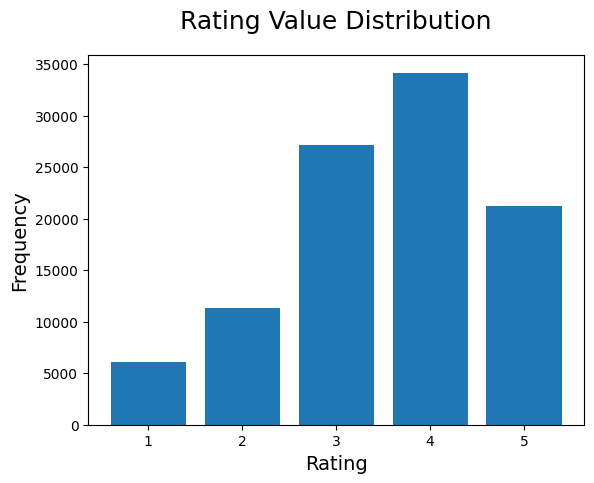

In [12]:
weights = list(edge[2]['weight'] for edge in G.edges(data=True))
unique, count = np.unique(weights, return_counts=True)

titlesize = 18
labelsize = 14

plt.bar(unique, count)
plt.title("Rating Value Distribution", size=titlesize, y=1.05)
plt.xlabel("Rating", size=labelsize)
plt.ylabel("Frequency", size=labelsize);
np.mean(weights), np.std(weights)

save_figure("bipartite_rating_value_distribution.png")

### Visualizing Degree Distributions

In [13]:
def plot_ccdf(degree_dictionary, cumulative=True):  # takes dict(G.degree)
   dd = Counter(degree_dictionary.values())
   dd = pd.DataFrame(list(dd.items()), columns = ("degree", "count")).sort_values(by = "degree")
   ccdf = dd.sort_values(by = "degree", ascending = False)
   if cumulative:
      ccdf["cumsum"] = ccdf["count"].cumsum()
      ccdf["ccdf"] = ccdf["cumsum"] / ccdf["count"].sum()
      ccdf = ccdf[["degree", "ccdf"]].sort_values(by = "degree")
   return ccdf

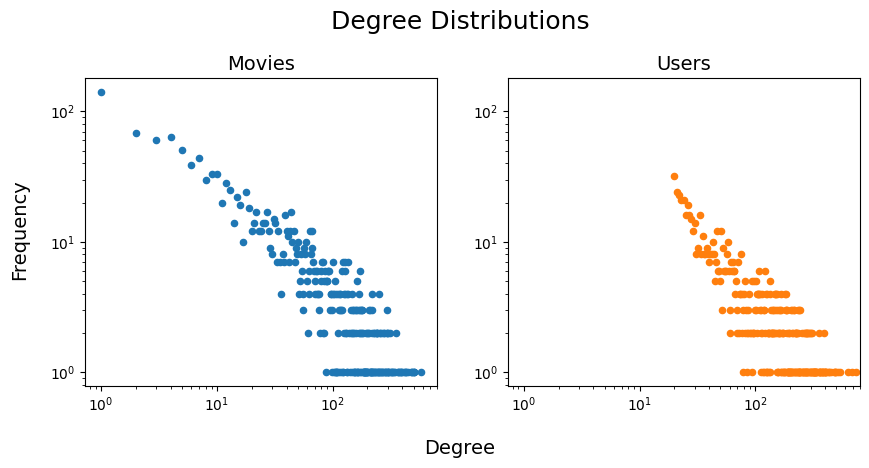

In [14]:
movie_degrees = {k:v for k,v in dict(G.degree()).items() if k < 10000}
user_degrees = {k:v for k,v in dict(G.degree()).items() if k >= 10000}

movie_dd = plot_ccdf(movie_degrees, cumulative=False)
user_dd = plot_ccdf(user_degrees, cumulative=False)

fig, ax = plt.subplots(1,2, figsize=(10,4))
fig.suptitle("Degree Distributions", size=titlesize, y=1.05)
fig.supylabel("Frequency", x=0.05, size=labelsize)
fig.supxlabel("Degree", y=-0.07, size=labelsize)

movie_dd.plot(kind='scatter', x='degree', y='count', loglog=True, ax=ax[0], ylabel='', xlabel='')
user_dd.plot(kind='scatter', x='degree', y='count', loglog=True, ax=ax[1], color='C1', ylabel='', xlabel='')                   

ax[0].set_title("Movies", size=labelsize)
ax[1].set_title("Users", size=labelsize)

# Keeping axis limits consistent and centering xlabel
ax[1].set_xlim(ax[0].get_xlim())
ax[1].set_ylim(ax[0].get_ylim())
# ax[0].xaxis.set_label_coords(1.1, -0.11)

save_figure("bipartite_dd_movies_and_users.png")

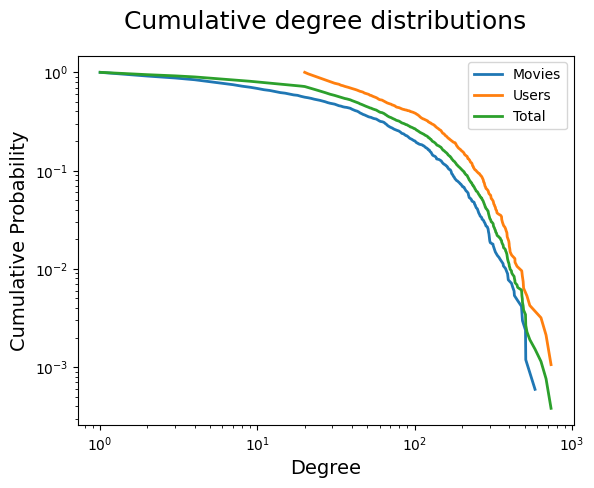

In [15]:
ax = plt.gca()

movie_ccdf = plot_ccdf(movie_degrees)
user_ccdf = plot_ccdf(user_degrees)
total_ccdf = plot_ccdf(dict(G.degree()))
            
movie_ccdf.plot(kind='line', x='degree', y='ccdf', loglog=True, label='Movies', ax=ax, linewidth=2)
user_ccdf.plot(kind='line', x='degree', y='ccdf', loglog=True, label='Users', ax=ax, linewidth=2)
total_ccdf.plot(kind='line', x='degree', y='ccdf', loglog=True, label='Total', ax=ax, linewidth=2)

ax.set_title("Cumulative degree distributions", size=titlesize, y=1.05)                       
plt.ylabel("Cumulative Probability", size=labelsize)
plt.xlabel("Degree", size=labelsize)
                       
save_figure("bipartite_ccdf_movies_and_users.png")

In [16]:
min(user_degrees.values()), min(movie_degrees.values()), float(1-movie_ccdf[movie_ccdf['degree'] == 20]['ccdf'].iloc[0])

(20, 1, 0.4417360285374554)

In [17]:
max(user_degrees.values()), max(movie_degrees.values())

(737, 583)

The distributions are not power law; they are shifted and there is exponential cutoff. 20 is the obvious minumum of movies rated by any user, since users with fewer than 20 ratings were discarded when making the data set. Some movies on the other hand have very few ratings, the minimum being 1. 44% of movies are rated by 20 or less people.